In [39]:
import pandas as pd
import numpy as np
from ast import literal_eval

The goal could be to determine if a movie is worth watching, by predicting its score based on certain features

Firstly, I will load up the data

In [40]:
credits = pd.read_csv('credits.csv')
titles = pd.read_csv('titles.csv')

credits.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [41]:
people_per_film = credits.groupby('id')['name'].apply(set).reset_index()
people_per_film.head()

,id,name
0,tm1000037,"{Edin Hasanović, Daniela Hirsh, Mélanie Fouché..."
1,tm1000147,"{Colin Salmon, Jonathan Aris, Antonia Campbell..."
2,tm100015,"{T.I., Johnathon Schaech, Steve Harris, Nichol..."
3,tm1000166,"{Marcello Tahitoe, M. Irfan Ramli, Saron Sakin..."
4,tm1000185,"{Mateusz Banasiuk, Wojciech Kalarus, Jarosław ..."


In [42]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


Now that I have loaded the data, it is time to begin some pre-processing steps. The goal of this project is to compare two models for MOVIES, as such, I will get rid of all the shows.

In [43]:
titles = titles[titles['type'] == 'MOVIE']
titles = titles.drop(columns=['seasons'])
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",tt0061578,7.7,72662.0,20.398,7.600
6,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],tt0079470,8.0,395024.0,17.770,7.800


Since there we are comparing the score, to make the analysis more meaningful, it is approrpriate to filter out any films that do not have enough votes to be a meaningful score. To determine this, firstly I will find some descriptive statistics

In [44]:
import matplotlib.pyplot as plt

Get rid of NaN votes first

In [45]:
titles = titles.dropna(subset=['imdb_votes'])

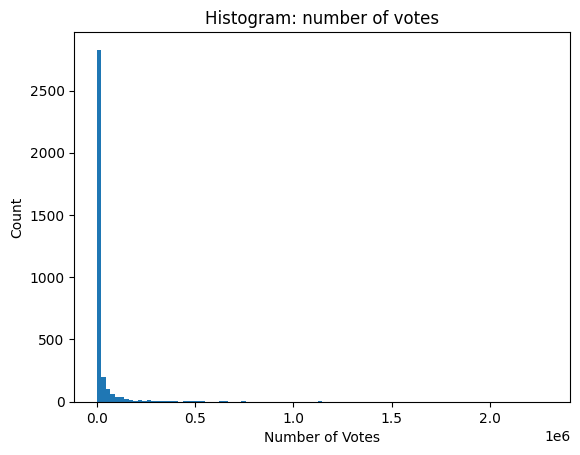

In [46]:
plt.hist(titles['imdb_votes'], bins = 100)

plt.title('Histogram: number of votes')
plt.xlabel('Number of Votes')
plt.ylabel('Count')

plt.show()

Here we can see there are MANY positive outliers. That's okay because more votes is more informative. We really want to remove the bottom level

In [47]:
votes_series = titles['imdb_votes']
votes_series = votes_series.sort_values()
votes_series.head(275)

4564      5.0
4470      5.0
2798      5.0
1049      6.0
5199      6.0
        ...  
4583     99.0
3538    100.0
2958    101.0
1685    101.0
2943    102.0
Name: imdb_votes, Length: 275, dtype: float64

We will get rid of about 271 values if we cut off at 100. Also drop the ones that don't have a score

In [48]:
titles = titles[titles['imdb_votes'] >= 500]
titles = titles.dropna(subset = ['imdb_score'])
titles = titles.dropna(subset = ['tmdb_score'])


NEXT: make a composite score. We are making the following assumptions here:

- Since there are no votes for TMDB, we assume that if it has many votes on IMDB, it has garned similar enough attention on TMDB, so the filtering still applies
- IMDB and TMDB scores are equally as important. As such, we will do a 50/50 weight

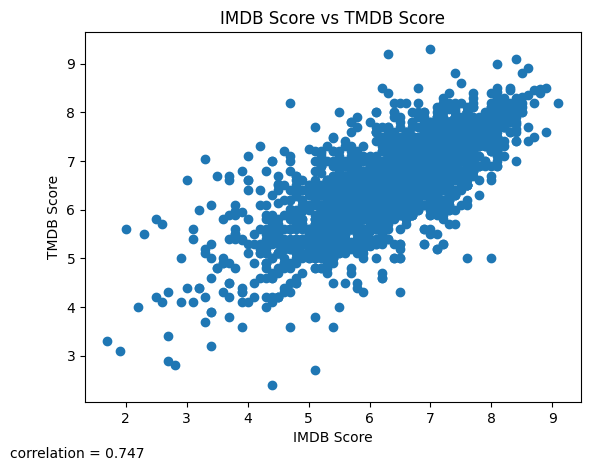

In [49]:
plt.scatter(titles['imdb_score'], titles['tmdb_score'])

plt.title('IMDB Score vs TMDB Score')
plt.ylabel('TMDB Score')
plt.xlabel('IMDB Score')

correlation = titles['imdb_score'].corr(titles['tmdb_score'])
plt.text(0.1, 0.9, f"correlation = {round(correlation,3)}")

plt.show()

They are strongly correlated, so it is appropriate in our opinion to make a combined score

In [50]:
titles['composite_score'] = 0.5 * titles['imdb_score'] + 0.5 * titles['tmdb_score']

Now to make our models work, we need to have categories. To do this, we must BIN the composite score. This DISCRETIZATION will be useful for our models.

There are many types of Discretization. It is appropriate to apply some domain knowledge here, so long as the categories are applied to both datasets. In our experience, we will be classifying movies as follows:

GOOD: composite_score >= 7.0
OKAY: 7.0 > composite_score >= 6.0
BAD: 6.0 > composite_score

I will make a function for this:

In [51]:
def label_score(value):
    if value >= 7.0:
        return 'GOOD'
    elif 7.0 > value >= 6.0:
        return 'OKAY'
    else:
        return 'BAD'

In [52]:
titles['score_label'] = titles['composite_score'].apply(label_score)
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,composite_score,score_label
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],tt0075314,8.2,808582.0,40.965,8.179,8.1895,GOOD
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],tt0068473,7.7,107673.0,10.010,7.300,7.5000,GOOD
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],tt0071853,8.2,534486.0,15.461,7.811,8.0055,GOOD
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",tt0061578,7.7,72662.0,20.398,7.600,7.6500,GOOD
6,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],tt0079470,8.0,395024.0,17.770,7.800,7.9000,GOOD


To check, although they aren't all equal frequency, they all have enough data points at more than 700 each

In [53]:
label_counts = titles['score_label'].value_counts()
print(label_counts)

score_label
OKAY    1065
GOOD     774
BAD      757
Name: count, dtype: int64


Do an inner join on the people set:

In [54]:
merged_titles = pd.merge(people_per_film, titles, on= 'id', how='inner')
merged_titles.tail(10)

,id,name,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,composite_score,score_label
2584,tm996762,"{Prakash Raj, Revathi, Murali Sharma, Anish Ku...",Major,MOVIE,Based on the life of real-life Hero Major Sand...,2022,NaN,149,"['action', 'drama']",['IN'],tt9851854,9.1,7576.0,6.429,8.188,8.644,GOOD
2585,tm99776,"{Whitney Cummings, John Fortenberry}",Whitney Cummings: Money Shot,MOVIE,"Taped at Washington D.C.’s Sidney Harmon Hall,...",2010,NaN,48,"['comedy', 'documentation']",['US'],tt1659261,6.2,917.0,2.718,5.900,6.050,OKAY
2586,tm998033,"{Ilavarasu, Bjorn Surrao, Sivakarthikeyan, Pri...",Doctor,MOVIE,An army doctor helps his love interest's famil...,2021,NaN,150,"['action', 'comedy', 'thriller', 'crime']",['IN'],tt11374902,7.5,15385.0,3.878,6.700,7.100,GOOD
2587,tm998188,"{Melani Olivares, Raúl Arévalo, Álvaro Cervant...",More the Merrier,MOVIE,Multiple stories about the oscillating world o...,2021,NaN,112,"['romance', 'comedy']",['ES'],tt6925902,5.4,3302.0,83.397,6.700,6.050,OKAY
2588,tm998238,"{Hamad Fathy Abu El Reesh, Salah Abdallah, Moh...",The Humans & the Mongoose,MOVIE,The story follows a poor government employee w...,2021,NaN,120,"['comedy', 'fantasy', 'horror']",['EG'],tt13043436,5.4,995.0,3.781,5.000,5.200,BAD
2589,tm998726,"{Blaise Afonso, Baptiste Leclercq, Grigory Col...",Sentinelle,MOVIE,Transferred home after a traumatizing combat m...,2021,NaN,80,"['thriller', 'action', 'drama', 'crime']",['FR'],tt11734264,4.7,7844.0,59.784,5.900,5.300,BAD
2590,tm998858,"{Brian Regan, Troy Miller}",Brian Regan: On the Rocks,MOVIE,Brian Regan tackles the big issues weighing on...,2021,NaN,58,['comedy'],['US'],tt13926994,6.8,619.0,1.875,6.800,6.800,OKAY
2591,tm998899,"{Kang Quintus, Ramsey Nouah, Prince Sube Mayor...",The Fisherman's Diary,MOVIE,A 12-year old girl - Ekah (Faith Fidel) is ins...,2020,NaN,142,['drama'],['CM'],tt13297136,6.4,631.0,4.522,7.100,6.750,OKAY
2592,tm999817,"{Tang Xiaoxi, Zhang Biyu, Zhang Fuzheng, Zhao ...",Green Snake,MOVIE,While trying to free her sister from Fahai's c...,2021,NaN,131,"['fantasy', 'animation', 'action']",['CN'],tt15000314,6.8,2348.0,15.949,8.500,7.650,GOOD
2593,tm999927,"{Leonardo Alonso, María Teresa Hernández Cañas...",A Cop Movie,MOVIE,This documentary walks the line between fact a...,2021,R,107,"['drama', 'crime', 'thriller', 'documentation'...",['MX'],tt14035242,7.0,1739.0,10.354,7.300,7.150,GOOD


We should one-hot encode the genres, description and key people (once joined)

In [55]:
# titles['genres'] = titles['genres'].apply(literal_eval).apply(set)
# exploded_genres_titles = titles.explode('genres') # explode the genres
# encoded_genres_titles = pd.get_dummies(exploded_genres_titles, columns = ['genres'], prefix = '', prefix_sep = '').groupby(level=0).sum()

# titles = pd.concat([titles, encoded_genres_titles], axis = 1)

# titles.head()

In [56]:
# from sklearn.feature_selection import mutual_info_classif
# print(sklearn.__version__)




1.3.0
